We will work with the [Palmer Archipelago (Antarctica) penguin dataset](https://github.com/allisonhorst/palmerpenguins) as an alternative to the [Iris flower dataset](https://www.kaggle.com/datasets/vikrishnan/iris-dataset). The penguin dataset is a good dataset for data exploration, visualization, and benchmarking cluster reduction algorithms in unspervised machine learning.

![](https://imgur.com/orZWHly.png)

Source: Allison Horst https://github.com/allisonhorst/penguins

Let's import the dataset and explore it to understand it better.

In [1]:
!pip install umap-learn

In [24]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn import metrics
import umap

# Visualisation libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Increase the default plot size and set the color scheme
plt.rcParams['figure.figsize'] = 8, 5
plt.style.use("fivethirtyeight")# for pretty graphs

# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# Reading in the dataset

In [3]:
penguin_df = pd.read_csv('penguins_size.csv')
penguin_df.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [4]:
penguin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


The dataframe consists of 7 columns including:

* `species`: penguin species (Chinstrap, Adélie, or Gentoo)
* `culmen_length_mm`: culmen length (mm)
* `culmen_depth_mm`: culmen depth (mm)
* `flipper_length_mm`: flipper length (mm)
* `body_mass_g`: body mass (g)
* `island`: island name (Dream, Torgersen, or Biscoe) in the Palmer Archipelago (Antarctica)
* `sex`: sex of penguin

## What are culmen length & depth?
The culmen is the upper ridge of a bird's beak.

![](https://pbs.twimg.com/media/EaAXQn8U4AAoKUj?format=jpg&name=4096x4096)


## What are flippers?
Penguins wings are called flippers. They are flat, thin, and broad with a long, tapered shape and a blunt, rounded tip

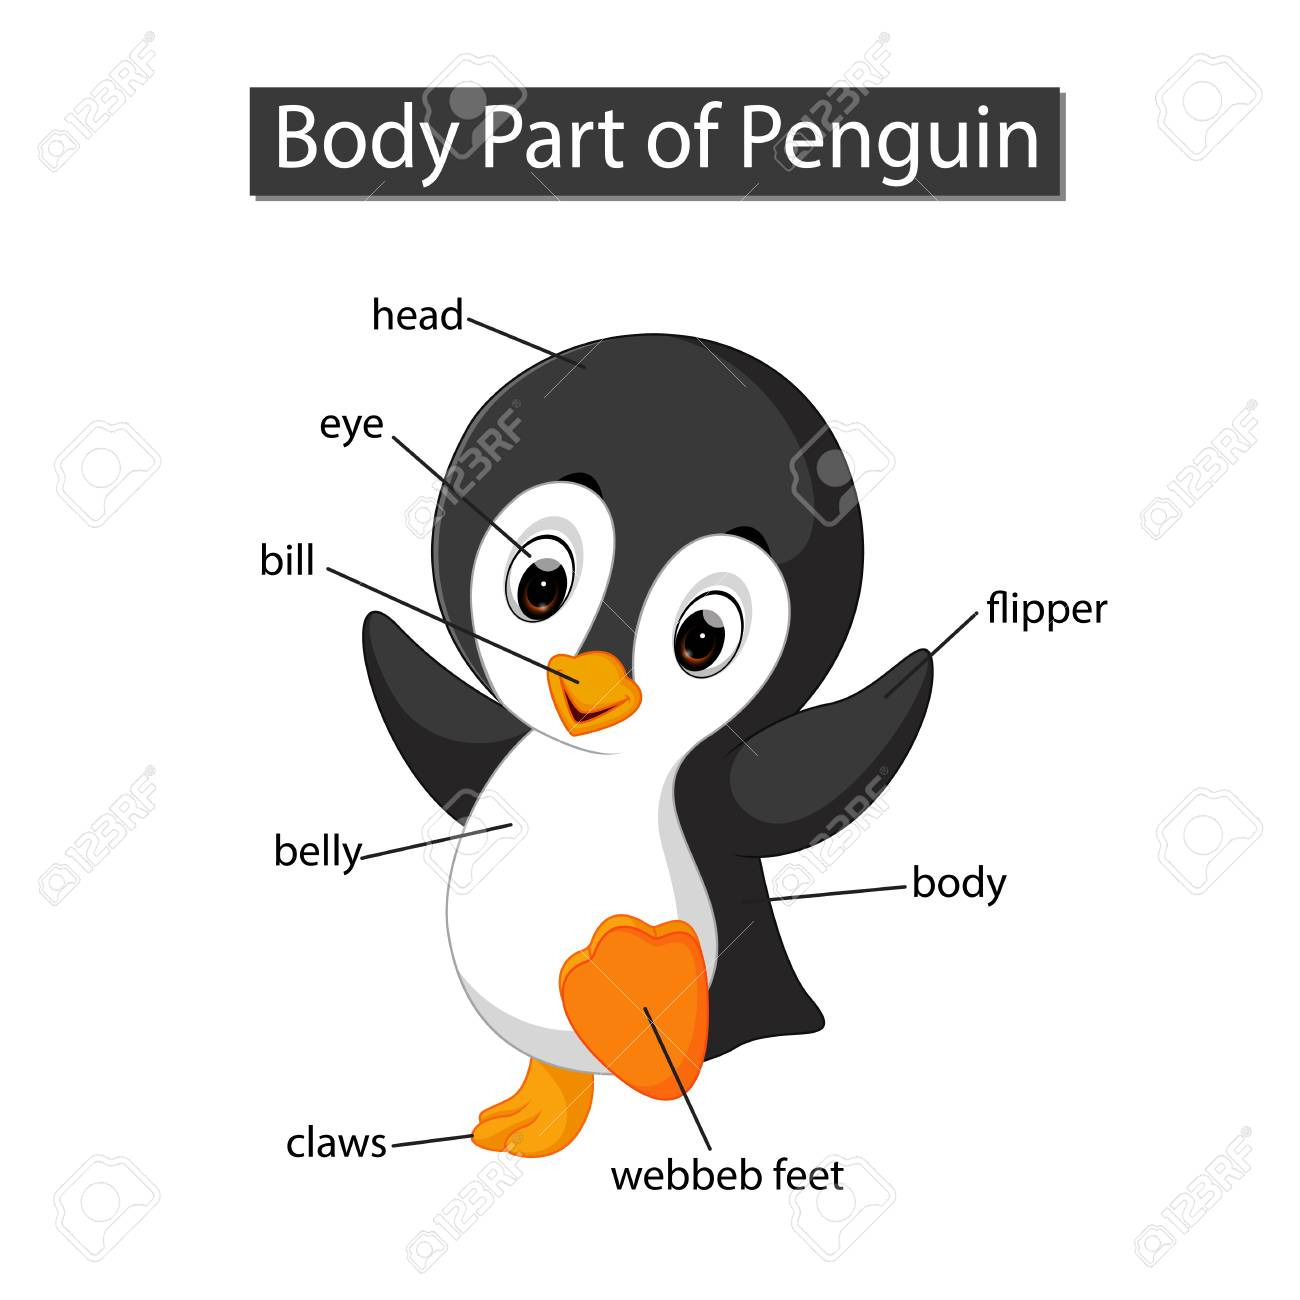

# Understanding the data



In [5]:
print(penguin_df.shape)

(344, 7)


In [6]:
penguin_df.describe(include='all')

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
count,344,344,342.000000,342.000000,342.000000,342.000000,334
unique,3,3,NaN,NaN,NaN,NaN,3
top,Adelie,Biscoe,NaN,NaN,NaN,NaN,MALE
freq,152,168,NaN,NaN,NaN,NaN,168
mean,NaN,NaN,43.921930,17.151170,200.915205,4201.754386,NaN
std,NaN,NaN,5.459584,1.974793,14.061714,801.954536,NaN
min,NaN,NaN,32.100000,13.100000,172.000000,2700.000000,NaN
25%,NaN,NaN,39.225000,15.600000,190.000000,3550.000000,NaN
50%,NaN,NaN,44.450000,17.300000,197.000000,4050.000000,NaN
75%,NaN,NaN,48.500000,18.700000,213.000000,4750.000000,NaN


## Correlation

We now plot a heatmap of the corrrelation between columns to see which features are related to other features.

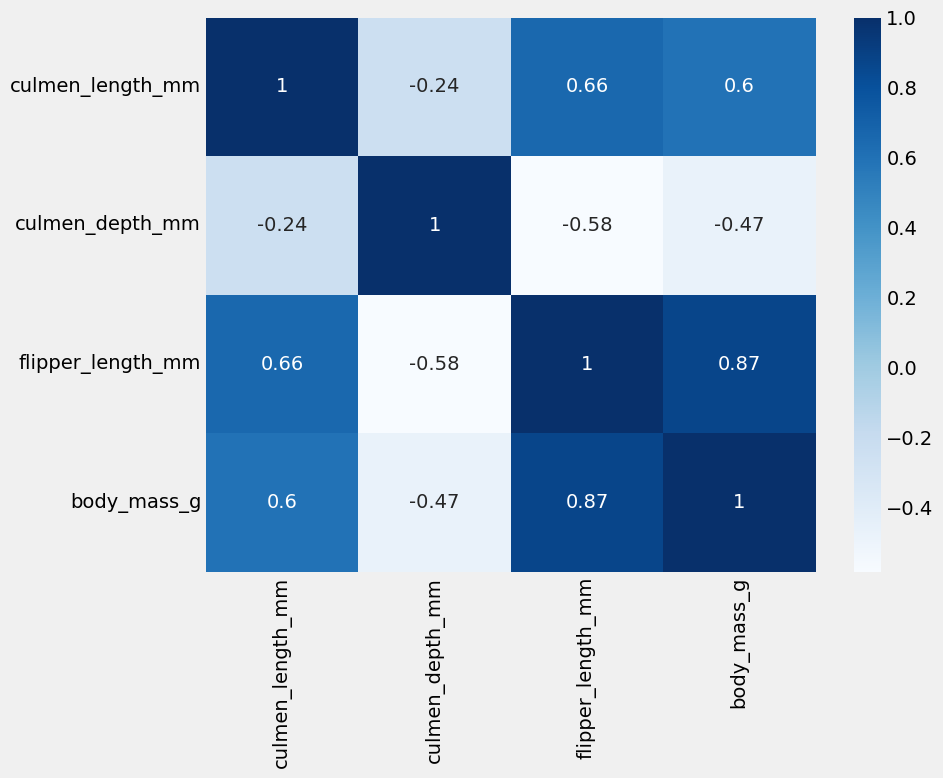

In [7]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(penguin_df.corr(), cmap='Blues', annot=True, ax=ax)

plt.tight_layout()
plt.show()

We then create a helper function for missing values.

In [8]:
# Source: https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction.
# A good notebook on getting started with a ML problem.

def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()

        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")

        # Return the dataframe with missing information
        return mis_val_table_ren_columns

## Missing values

In [9]:
missing= missing_values_table(penguin_df)
missing

Your selected dataframe has 7 columns.
There are 5 columns that have missing values.


,Missing Values,% of Total Values
sex,10,2.9
culmen_length_mm,2,0.6
culmen_depth_mm,2,0.6
flipper_length_mm,2,0.6
body_mass_g,2,0.6


In [10]:
# Handling missing values

from sklearn.impute import SimpleImputer
#setting strategy to 'most frequent' to impute by the mean
imputer = SimpleImputer(strategy='most_frequent')# strategy can also be mean or median
penguin_df.iloc[:,:] = imputer.fit_transform(penguin_df)

In [11]:
penguin_df.isnull().sum()

species              0
island               0
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

## Convert sex column to integer values

We also convert categorical data to numerical data.

In [12]:
lb = LabelEncoder()
penguin_df["sex"] = lb.fit_transform(penguin_df["sex"])
penguin_df['sex'][:5]

0    2
1    1
2    1
3    2
4    1
Name: sex, dtype: int64

# Analysing the data visually

## Number of Species

In [13]:
penguin_df['species'].value_counts()

Adelie       152
Gentoo       124
Chinstrap     68
Name: species, dtype: int64

Unlike Iris (which has equal number of all the species of flowers), the penguins dataset has different number of samples for each species.

<Axes: >

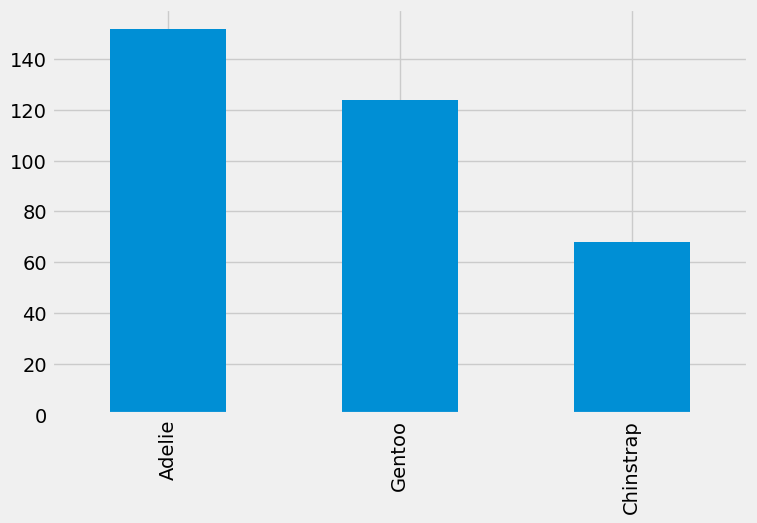

In [14]:
penguin_df['species'].value_counts().plot(kind='bar')

# Boxplot

The box plot will show us the visual representation of how our data is scattered.

<Axes: >

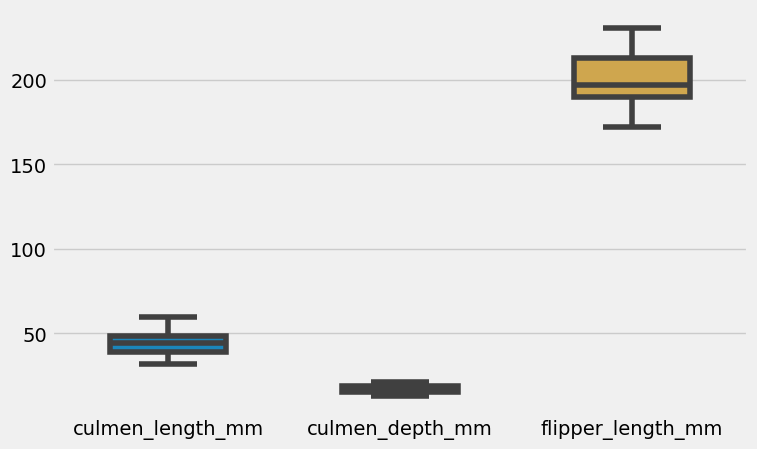

In [15]:
penguin_df1 = penguin_df[['culmen_length_mm', 'culmen_depth_mm','flipper_length_mm']]
sns.boxplot(data=penguin_df1, width=0.5,fliersize=5)

# Scatterplot
The scatter plot shows us the correlation with respect to other features. This method helps us identify important features which account for most of the variance in our model.

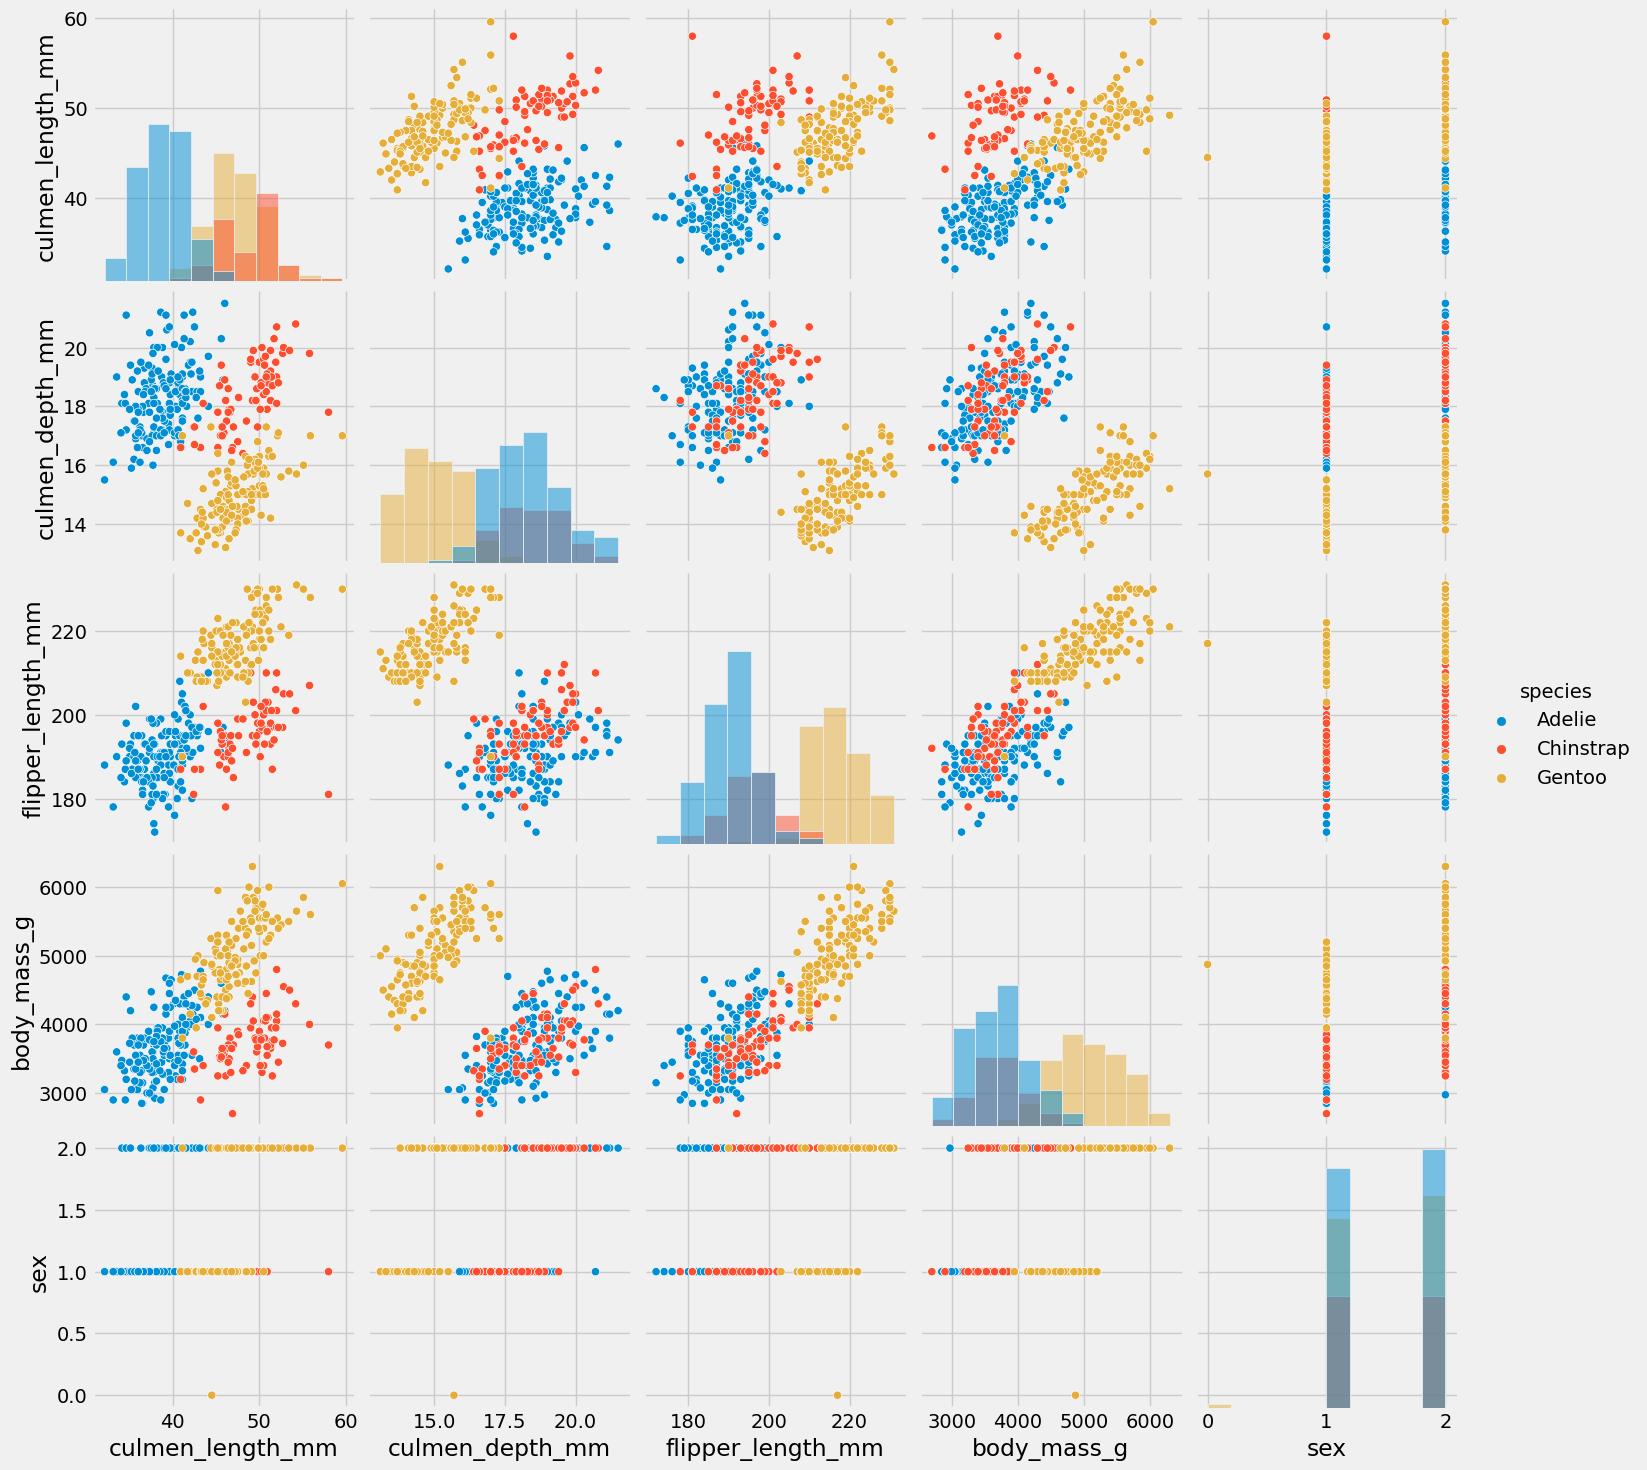

In [16]:
sns.pairplot(penguin_df, hue="species", size=3,diag_kind="hist")

We also explore several other plots between our features.

## culmen_depth vs culmen_length

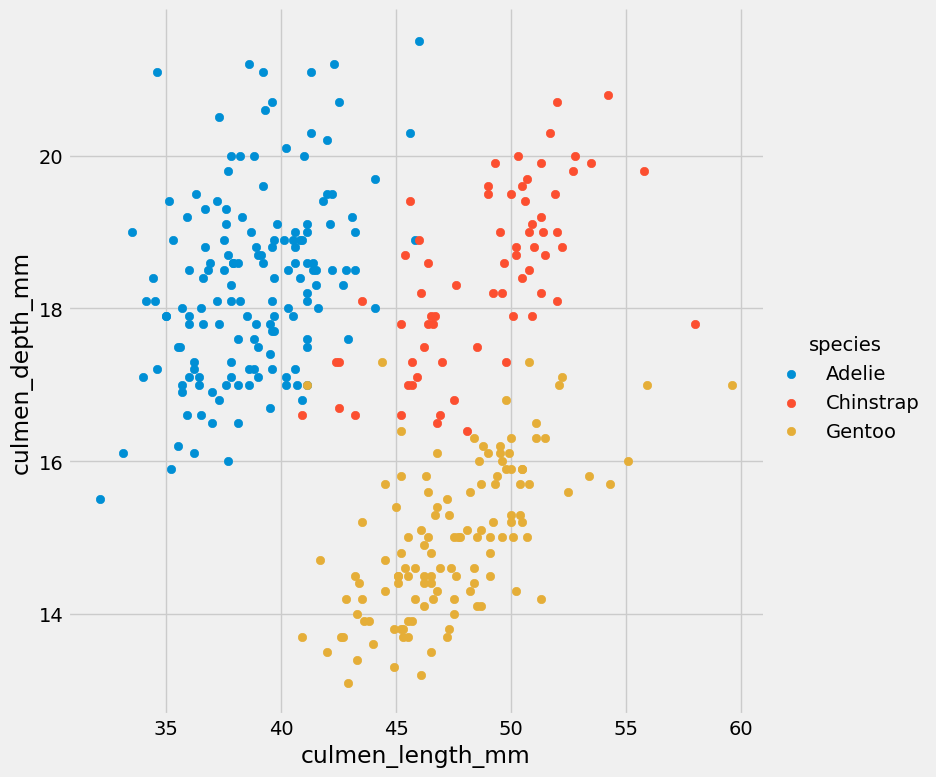

In [17]:
sns.FacetGrid(penguin_df, hue="species", height=8) \
   .map(plt.scatter, "culmen_length_mm", "culmen_depth_mm") \
   .add_legend()

## culmen_depth vs flipperlength


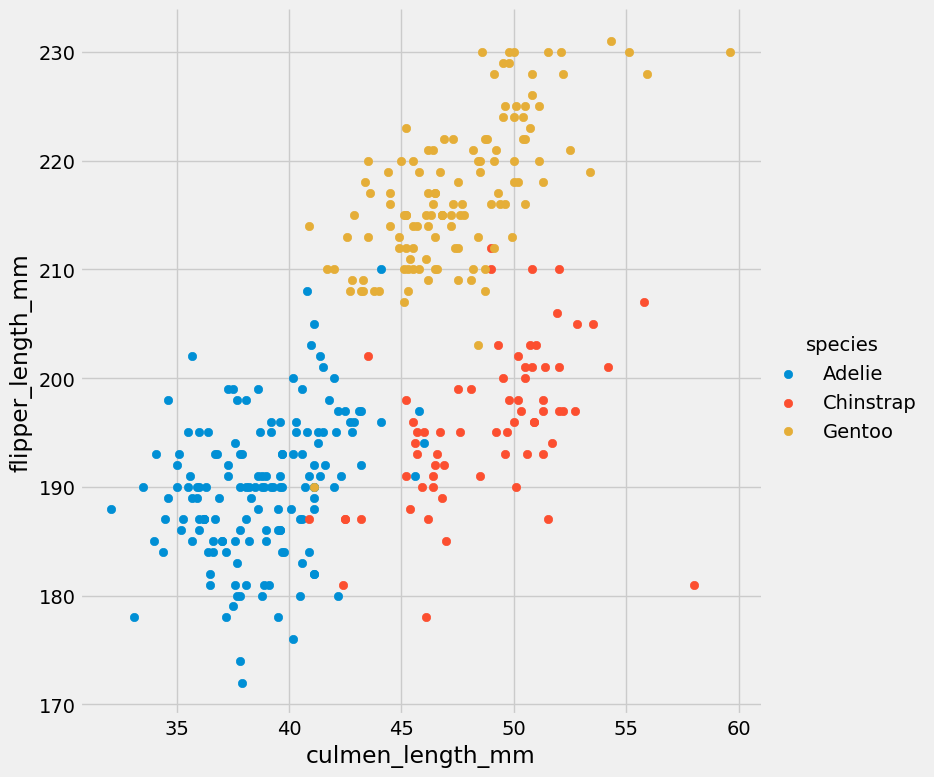

In [18]:
sns.FacetGrid(penguin_df, hue="species", height=8) \
   .map(plt.scatter, "culmen_length_mm", "flipper_length_mm") \
   .add_legend()

# Flipperlength distribution

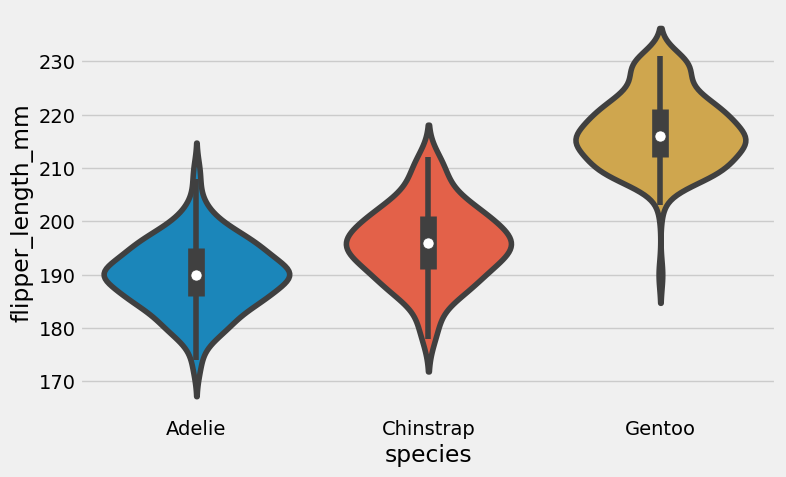

In [19]:
ax = sns.violinplot(x="species", y="flipper_length_mm", data=penguin_df,size=8)


## KDEPlot

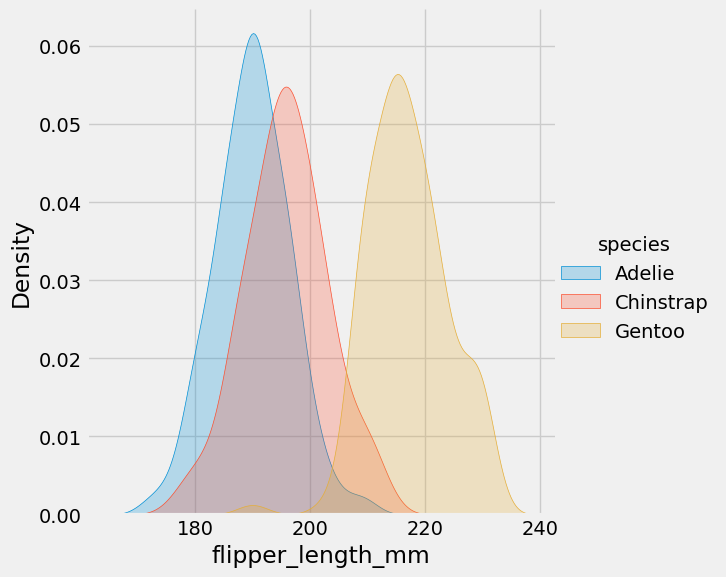

In [20]:
sns.FacetGrid(penguin_df, hue="species", height=6) \
   .map(sns.kdeplot, "flipper_length_mm",shade=True) \
   .add_legend()

## Flipper length vs. body mass


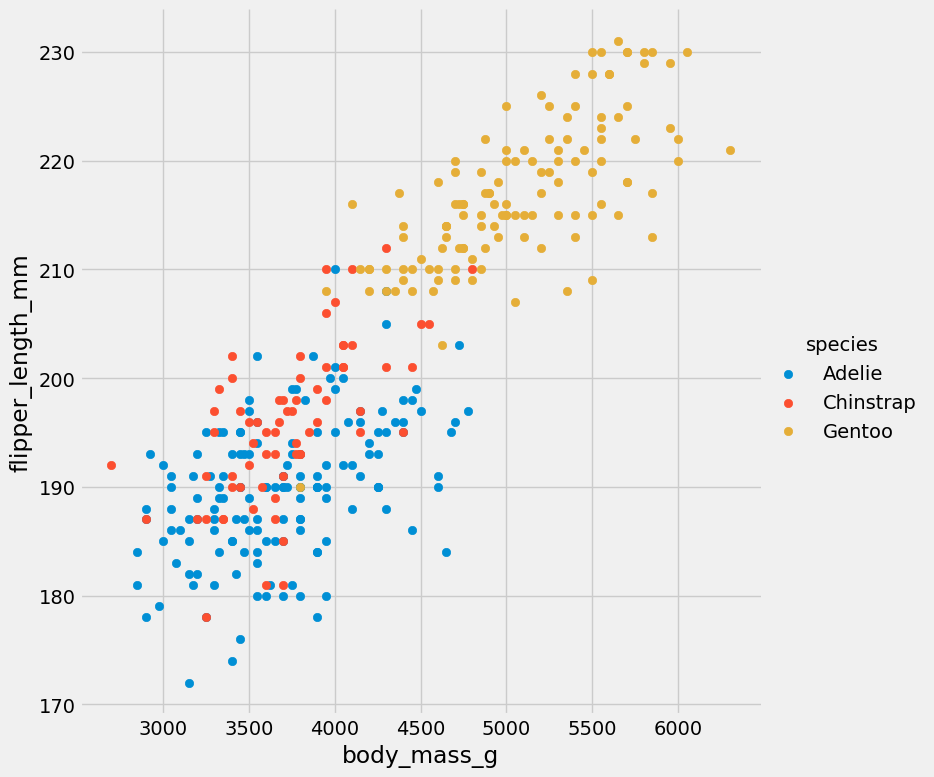

In [21]:
sns.FacetGrid(penguin_df, hue="species", height=8) \
   .map(plt.scatter, "body_mass_g", "flipper_length_mm") \
   .add_legend()

We will now setup our data for clustering (dimensionality reduction techniques). We first scale the data.

# Scale the dataset

In [22]:
X = penguin_df[['culmen_length_mm','culmen_depth_mm','flipper_length_mm']].values
y = penguin_df['body_mass_g'].values
X_std = StandardScaler().fit_transform(X)

Next, we look at the `silhouette_score` using Hierarchical clustering, DBSCAN, and Gaussian mixture models to see which technique works best without labeled data.

# Hierarchical clustering

In [25]:
# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage='complete',
                                      affinity='cosine',
                                      n_clusters=3)

# Fit model
clusters = agg_cluster.fit_predict(X_std)
print("Adjusted Rand Index of the Agglomerative Clustering solution: {}"
      .format(metrics.adjusted_rand_score(y, clusters)))
print("The silhouette score of the Agglomerative Clustering solution: {}"
      .format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

Adjusted Rand Index of the Agglomerative Clustering solution: 0.0159864044490442
The silhouette score of the Agglomerative Clustering solution: 0.4946949272092665


## DBSCAN

In [26]:
# Defining the agglomerative clustering
dbscan_cluster = DBSCAN(eps=1, min_samples=5)

# Fit model
clusters = dbscan_cluster.fit_predict(X_std)
print("Adjusted Rand Index of the DBSCAN solution: {}"
      .format(metrics.adjusted_rand_score(y, clusters)))
print("The silhouette score of the DBSCAN solution: {}"
      .format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

Adjusted Rand Index of the DBSCAN solution: -0.00018765013014962988
The silhouette score of the DBSCAN solution: 0.3176345158731045


## Gaussian mixture models

In [27]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=3)

# Fit model
clusters = gmm_cluster.fit_predict(X_std)
print("Adjusted Rand Index of the GMM solution: {}"
      .format(metrics.adjusted_rand_score(y, clusters)))
print("The silhouette score of the GMM solution: {}"
      .format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

Adjusted Rand Index of the GMM solution: 0.016296558628073464
The silhouette score of the GMM solution: 0.4934261627505387


From here we see that GMM returns the highest combination of `adjusted_rand_score` and `silhouette_score` and is therefore more effective than Hierarchical clustering and DBSCAN for our penguin dataset.

Finally, we perform PCA, t-SNE, and UMAP to visualize dimensionality reduction techniques.

# PCA

In [28]:
pca = PCA(n_components=2)
pca_embedding = pca.fit_transform(X_std)
pca_embedding.shape

(344, 2)

Text(0.5, 1.0, 'PCA projection of the Penguin dataset')

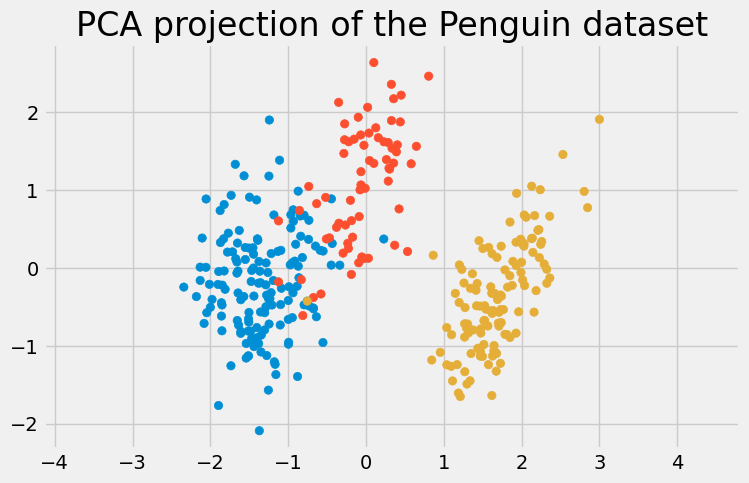

In [29]:
plt.scatter(
    pca_embedding[:, 0],
    pca_embedding[:, 1],
    c=[sns.color_palette()[x] for x in penguin_df.species.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})])
plt.gca().set_aspect('equal', 'datalim')
plt.title('PCA projection of the Penguin dataset', fontsize=24)

# t-SNE

In [30]:
tsne = TSNE()
tsne_embedding = tsne.fit_transform(X_std)
tsne_embedding.shape

(344, 2)

Text(0.5, 1.0, 't-SNE projection of the Penguin dataset')

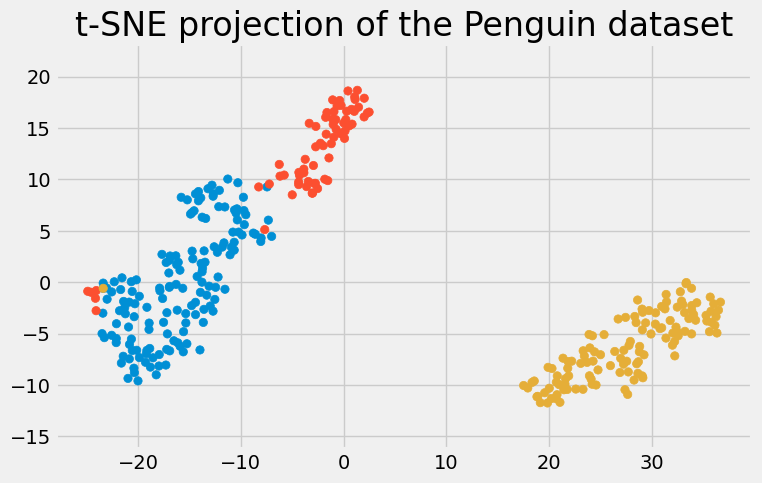

In [31]:
plt.scatter(
    tsne_embedding[:, 0],
    tsne_embedding[:, 1],
    c=[sns.color_palette()[x] for x in penguin_df.species.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})])
plt.gca().set_aspect('equal', 'datalim')
plt.title('t-SNE projection of the Penguin dataset', fontsize=24)

# UMAP

In [32]:
umap_obj = umap.UMAP()
umap_embedding = umap_obj.fit_transform(X_std)
umap_embedding.shape

(344, 2)

Text(0.5, 1.0, 'UMAP projection of the Penguin dataset')

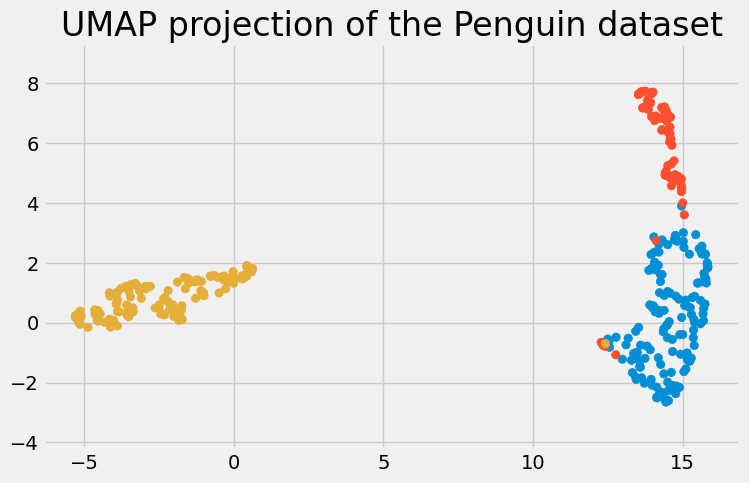

In [33]:
plt.scatter(
    umap_embedding[:, 0],
    umap_embedding[:, 1],
    c=[sns.color_palette()[x] for x in penguin_df.species.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Penguin dataset', fontsize=24)

From these, the t-SNE ansd UMAP reduction perform better than PCA and are our preferred dimensionality reduction techniques.